#Классификация новостей

In [1]:
from google.colab import files # Для работы с файлами
import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline
 
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from google.colab import drive # Для работы с Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Удаляем директорию с распакованными данными (если есть)
!rm -rf /content/cp5_news

In [4]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Machine_learning/Control_points/CP5_Texts_classification/cp5_news.zip' -d /content/

In [5]:
# Функция для загрузки файла
def loadText(fileName):
  f = open(fileName, 'r') # Открываем файл в режиме чтения
  text = f.read()         # Читаем текст
  text = text.replace("\n", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\r", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\t", " ") # Заменяем табуляции на пробелы
  f.close()
  
  return text

labels = ["Politics", "Sport", "Tech"] # Классифицируемые новости
labelsNum = len(labels) # Количество классифицируемых групп

In [6]:
# Загружаем тексты из обучающей и тренировочной выборок

trainText = [] # Обучающие тексты
validationText = [] # Проверочные тексты
testText = []  # Тестовые тексты

fileList = os.listdir('cp5_news/') # Получаем список всех файлов
print(fileList)
for label in labels:
  for file in fileList:
    if label in file: # Проверяем, содержит ли файл j в названии имя класса i
      if 'train' in file: # Если в имени найденного класса есть строка "train" 
        trainText.append(loadText('cp5_news/' + file)) #добавляем в обучающую выборку
        print(file, 'добавлен в обучающую выборку')
      if 'test' in file: # Если в имени найденного класса есть строка "test"
        testText.append(loadText('cp5_news/' + file)) # Добавляем в обучающую выборку
        print(file, 'добавлен в тестовую выборку')
      if 'validation' in file:
        validationText.append(loadText('cp5_news/' + file))
        print(file, 'добавлен в проверочную выборку')

['Tech test.txt', 'Sport train.txt', 'Politics test.txt', 'Tech train.txt', 'Tech validation.txt', 'Politics train.txt', 'Sport test.txt', 'Sport validation.txt', 'Politics validation.txt']
Politics test.txt добавлен в тестовую выборку
Politics train.txt добавлен в обучающую выборку
Politics validation.txt добавлен в проверочную выборку
Sport train.txt добавлен в обучающую выборку
Sport test.txt добавлен в тестовую выборку
Sport validation.txt добавлен в проверочную выборку
Tech test.txt добавлен в тестовую выборку
Tech train.txt добавлен в обучающую выборку
Tech validation.txt добавлен в проверочную выборку


In [7]:
print("Количество загруженных тренировочных текстов:", len(trainText))
print("Количество загруженных тестовых текстов:", len(testText))
print("Количество загруженных проверочных текстов:", len(validationText))

Количество загруженных тренировочных текстов: 3
Количество загруженных тестовых текстов: 3
Количество загруженных проверочных текстов: 3


In [8]:
# Примеры содержимого в тренировочных текстах
print(trainText[0][:100])
print(trainText[1][:100])
print(trainText[2][:100])

print("\n")

# Примеры содержимого в проверочных текстах
print(testText[0][:100])
print(testText[1][:100])
print(testText[2][:100])

   политика Россия Украина Сирия Европа США аналитика война Путин  В правительстве Украины заявили о
   Делимся впечатлениями от игры сборной  Матыцин назвал суммы премиальных, которые получат наши мед
 Софт и игры Обзор Part Time UFO: подработка инопланетянином от создателей Kirby   Битва ассистентов


﻿  политика Россия Украина Сирия Европа США аналитика война Путин  Цитату Байдена о "великом негре" 
 Ловите состав сборной на октябрьские матчи отбора ЧМ-2022.  Кто лишний? Кого не хватает? Сергей Пло
  Новинка, сочетающая в себе огромную батарею на 6000 мАч, камеру на 64 Мп и современный дизайн за в


Токенизируем тексты

In [9]:
numWords = 20000 # Количество слов/индексов, которое мы будем учитывать при обучении
# индекс - частота, с которой встречается слово

# Tokenizer - встроенная в Keras функция для разбиения текста и превращения
# слов в числовые значения (индексы) с учётом частотности

# num_words - максимальное количество слов/индексов, учитываемое при составлении словаря
# filters - список ненужных символов, которые будут удалены из текстов
# lower - приведение слов к нижнему регистру
# split - разделитель между словами
# oov_token - на какое слово будем заменять слова, которые выше по частоте, чем numWords
# char_level - просим токенайзер не удалять однобуквенные слова

tokenizer = Tokenizer(num_words=numWords,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText) # Cоберем словарь частотности
items = list(tokenizer.word_index.items()) # Получаем индексы слов

In [10]:
print("Самые часто встречающиеся слова:")
print(items[:10])
print()
print("Самые редко встречающиеся слова:")
print(items[-10:])
print()
print("Размер словаря:", len(items))

Самые часто встречающиеся слова:
[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('не', 6), ('что', 7), ('по', 8), ('за', 9), ('для', 10)]

Самые редко встречающиеся слова:
[('ming', 69837), ('chi', 69838), ('kuo', 69839), ('исчезут', 69840), ('начальную', 69841), ('воссоздали', 69842), ('sanktperkele', 69843), ('встроенного', 69844), ('достоверно', 69845), ('подошёл', 69846)]

Размер словаря: 69846


In [ ]:
# # Тестирование словаря
# inputWord = input("Введите слово: ")
# print("Индекс слова", inputWord, ":", tokenizer.word_index[inputWord])

Введите слово: путин
Индекс слова путин : 102


In [11]:
# Преобразовываем тексты в последовательности индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)
validationWordIndexes = tokenizer.texts_to_sequences(validationText)

In [12]:
# Проверим преобразование
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[2][:23])
print("Он же в виде последовательности индексов: ", trainWordIndexes[0][:5], '\n')

Фрагмент обучающего текста:
В виде оригинального текста:                Софт и игры Обзор Part
Он же в виде последовательности индексов:  [143, 49, 99, 164, 136] 



In [13]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], " "*(10-len(labels[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], ' '*(10-len(labels[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) # Считаем символы
  wordsTestText += len(testWordIndexes[i]) # Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Politics    1744978 символов,  238065 слов
Sport       1808908 символов,  262022 слов
Tech        1779783 символов,  253146 слов
----
В сумме  5333669  символов,  753233  слов 


Статистика по тестовым текстам:
Politics    197551 символов,  26851 слов
Sport       169031 символов,  24435 слов
Tech        186296 символов,  26250 слов
----
В сумме  552878  символов,  77536  слов


Создание выборок

In [14]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна

def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [15]:
# Задаём базовые параметры
xLen = 500 # Размер окна (количество слов в векторе)
step = 60 # Шаг разбиения текста на векторы

In [16]:
# Формируем выборки
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
xValidationId, yValidation = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности проверочного набора") #TODO:
print(xValidationId.shape)
print(yValidation.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)
print()


Размерности тренировочного набора
(12530, 500)
(12530, 3)

Размерности проверочного набора
(153, 500)
(153, 3)

Размерности тестового набора
(153, 500)
(153, 3)



In [17]:
print(xTrainId[0])

[  143    49    99   164   136    24   162   145   102     2  6658   106
   878    81  3074  2061     5   390    99  1751   666     2  1266  3074
   440     5   390   342  1027   747  5887  1785   106  1232     1     2
  2205     4  1644     2  1926   477  1362     4  2005     4 10642    20
    20    43    90  1751  6659     2  1266  3074   440     5   390   147
 13353  4641    11  2767     6     1     1     1     5 15446     4   706
   147  1563     1     1  2688     8     1   350    29    65    62  2311
    28    10    95    61    43    54    82     1     4   523   120   782
   266    25   150   178  1267  4240  2557     8  2897  1785     3     1
 10643  5596   234 13354  2108     5 18063     7    49 13355  1006   924
     4   706    11  2767     4   817   274 18064 10644    44    46  2612
  6660     3     1  1051  2767     6 18065   485   612  8187     7    49
     6 18066  1006    19    65   620  1588     2   401     5     1  4439
     5   306   221    49     5    20   108  9621  2

*Здесь RAM начинает быстро расходоваться*

In [18]:
# Преобразовываем массив векторов в Bag of Words
xTrain = tokenizer.sequences_to_matrix(xTrainId.tolist())
xTest  = tokenizer.sequences_to_matrix(xTestId.tolist())
xValidation = tokenizer.sequences_to_matrix(xValidationId.tolist())

print("Размерность обучайющей выборки")
print(xTrain.shape)
print(xTrain[0][0:100]) # Фрагмент набора слов в виде Bag of Words

print()

print("Размерность тестовой выборки")
print(xTest.shape)
print(xTest[0][0:100]) # Фрагмент набора слов в виде Bag of Words

print()

print("Размерность проверочной выборки")
print(xValidation.shape)
print(xValidation[0][0:100]) # Фрагмент набора слов в виде Bag of Words

Размерность обучайющей выборки
(12530, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1.]

Размерность тестовой выборки
(153, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1.]

Размерность проверочной выборки
(153, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 

Нейросеть для классификации текстов на базе Bag Of Words

In [19]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Dense(512, input_dim=20000, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               10240512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 10,242,051
Trainable params: 10,242,051
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=5, #20
                    batch_size=64,
                    validation_data= (xValidation, yValidation)
                    )

Epoch 1/5
196/196 [==============================] - 52s 265ms/step - loss: 4.3949e-07 - accuracy: 1.0000 - val_loss: 1.6423e-05 - val_accuracy: 1.0000
Epoch 2/5
196/196 [==============================] - 51s 258ms/step - loss: 1.9738e-07 - accuracy: 1.0000 - val_loss: 1.5183e-05 - val_accuracy: 1.0000
Epoch 3/5
196/196 [==============================] - 45s 228ms/step - loss: 1.3704e-07 - accuracy: 1.0000 - val_loss: 1.4203e-05 - val_accuracy: 1.0000
Epoch 4/5
196/196 [==============================] - 45s 227ms/step - loss: 1.1936e-07 - accuracy: 1.0000 - val_loss: 1.3539e-05 - val_accuracy: 1.0000
Epoch 5/5
196/196 [==============================] - 44s 224ms/step - loss: 9.9715e-08 - accuracy: 1.0000 - val_loss: 1.3037e-05 - val_accuracy: 1.0000


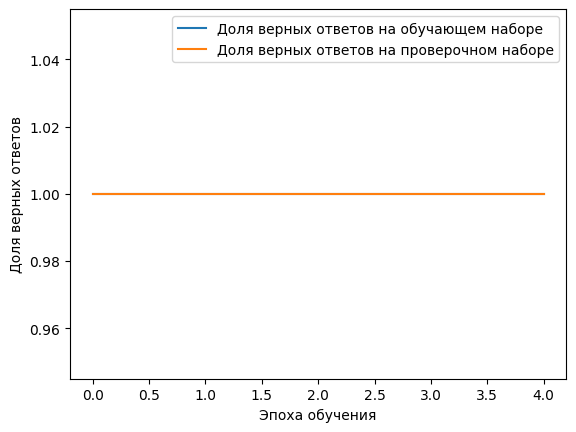

In [22]:
# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Проверка работы обученной нейросети

In [23]:
# Какие переменные имеют какой тип данных:
print("xTest = ", xTest)
print("xTest type = ", type(xTest))


xTest =  [[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
xTest type =  <class 'numpy.ndarray'>


In [27]:
# Какие переменные имеют какой тип данных:
print("yTest[:10] = ", yTest[:10])
print("yTest type = ", type(yTest))

yTest[:10] =  [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
yTest type =  <class 'numpy.ndarray'>


In [ ]:
# Проверяем точность на тестовой выборке

rightAnswer = [0,0,0]
totalAnswer = [0,0,0]

# Получаем результаты распознавания для каждого класса
currPred = model.predict(xTest)
# Определяем номер распознанного класса для каждого вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждого вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()


# Считаем сколько ответов всего и сколько из них правильных
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

# Подсчитываем точность классификации
print("Точность распознавания текстов новостей")
for i in range(labelsNum):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], rightAnswer[i], totalAnswer[i], (rightAnswer[i]/totalAnswer[i]*100)))

(153, 3)
(153,)
(153,)

Точность распознавания текстов новостей
Politics    :  53 из  53 - 100.00%
Sport       :  48 из  48 - 100.00%
Tech        :  52 из  52 - 100.00%
